# 캘리포니아 집값 예측하기: 회귀

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
# 산점도 행렬을 그리기 위해 seaborn 패키지를 설치합니다
!pip install seaborn

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.3.0


In [3]:
# 런타임에서 할당하는데 필요한 양만큼의 GPU 메모리를 할당
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

### California Housing Prices 데이터셋 로딩

In [5]:
dataset_path = "/content/drive/My Drive/dataset/housing.csv"
raw_dataset = pd.read_csv(dataset_path)

dataset = raw_dataset.copy()
dataset.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,78100,INLAND
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,77100,INLAND
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,92300,INLAND
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,84700,INLAND
20639,-121.24,39.37,16,2785,616.0,1387,530,2.3886,89400,INLAND


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


### 데이터 분포 분석

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2f71406588>,
      dtype=object)

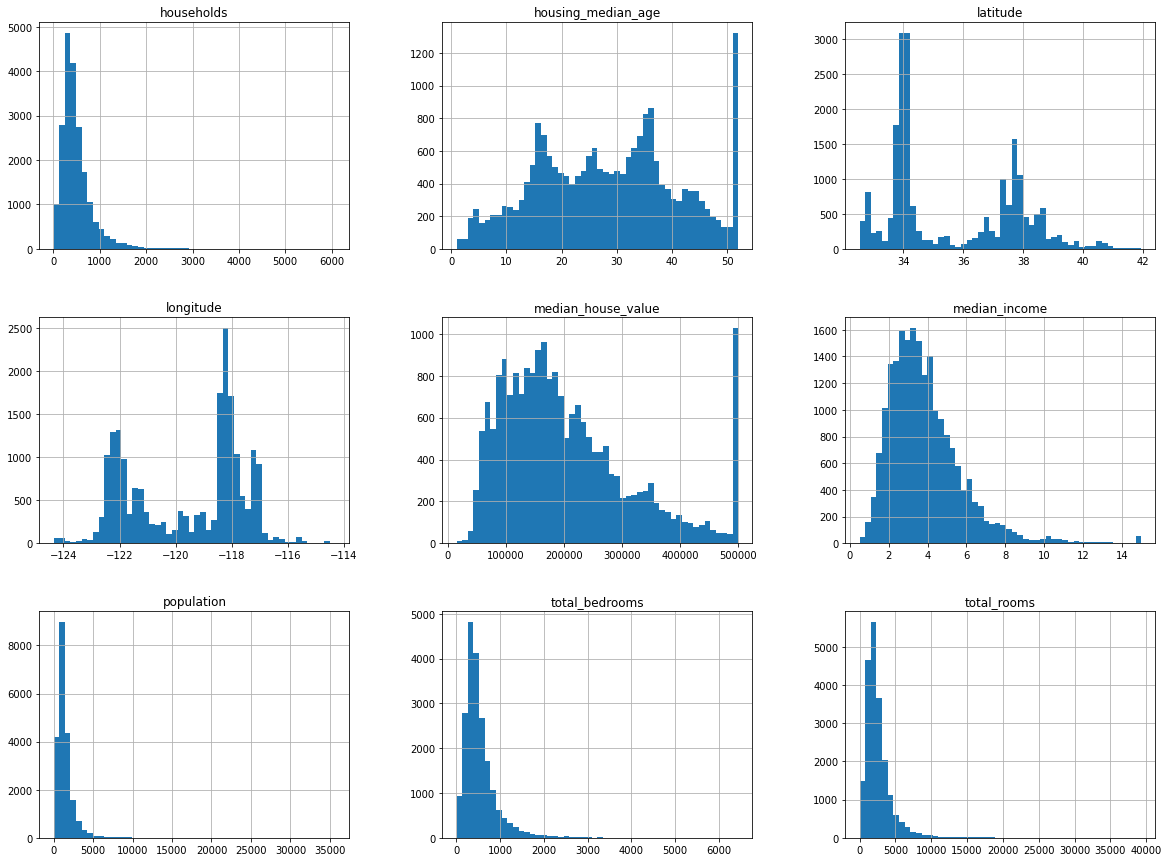

In [7]:
dataset.hist(bins=50, figsize=(20,15))
#2번째, 5번째 그래프를 보면 한 부분이 유독 높이 솟아오른 그래프를 볼 수 있는데 이를 outlier라 한다

In [8]:
#데이터 분포 분석
dataset_stats = dataset.describe()
dataset_stats = dataset_stats.transpose()
dataset_stats

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


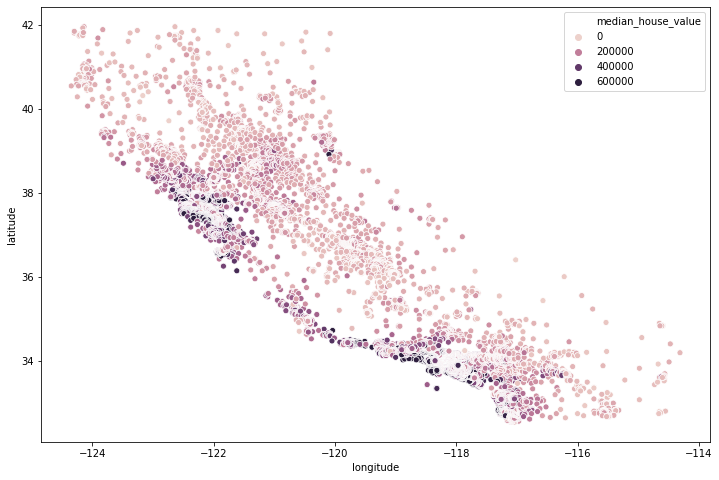

In [9]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='longitude', y='latitude',data=dataset,hue='median_house_value')

In [10]:
dataset.corr()
# corr함수는 Pearson Correlation Coefficient를 구함 -> 그룹 별로 변수 간 상관 관계 분석

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


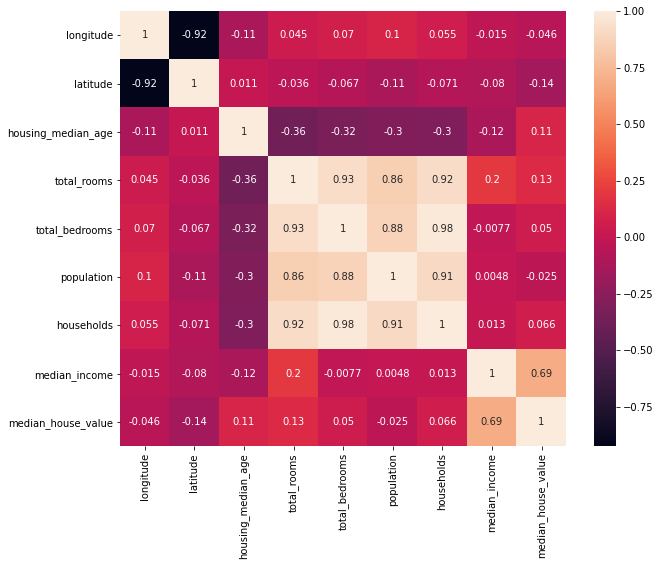

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(dataset.corr(), annot=True)

### 누락 데이터 삭제

In [12]:
# 먼저 누락 데이터를 확인하고 제거한다
print(dataset.isna()) #누락 데이터 조회
print(dataset.isna().sum())# 누락 데이터 개수 합산 -> 누락 데이터는 total_bedrooms column에서 207건 발견해야함
dataset = dataset.dropna()# 누락 데이터 제거
print(dataset) 
# 원래 [20640 rows x 10 columns] -> [20433 rows x 10 columns] 207 제거

       longitude  latitude  ...  median_house_value  ocean_proximity
0          False     False  ...               False            False
1          False     False  ...               False            False
2          False     False  ...               False            False
3          False     False  ...               False            False
4          False     False  ...               False            False
...          ...       ...  ...                 ...              ...
20635      False     False  ...               False            False
20636      False     False  ...               False            False
20637      False     False  ...               False            False
20638      False     False  ...               False            False
20639      False     False  ...               False            False

[20640 rows x 10 columns]
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population     

### 범주형 데이터 변환

In [13]:
# ocean_proximity column을 5개 column(NEAR BAY, <1H OCEAN , INLAND, NEAR OCEAN, ISLAND)으로 변경
# One-Hot Vector 형태의 5개 column 생성

ocean_proximity = dataset.pop('ocean_proximity')
ocean_proximity.value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64

In [14]:
dataset['<1H OCEAN'] = (ocean_proximity == "<1H OCEAN")*1.0
dataset['INLAND'] = (ocean_proximity == "INLAND")*1.0
dataset['NEAR OCEAN'] = (ocean_proximity == "NEAR OCEAN")*1.0
dataset['NEAR BAY'] = (ocean_proximity == "NEAR BAY")*1.0
dataset['ISLAND'] = (ocean_proximity == "ISLAND")*1.0

In [15]:
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,NEAR OCEAN,NEAR BAY,ISLAND
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,0.0,0.0,0.0,1.0,0.0


In [16]:
dataset.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,NEAR OCEAN,NEAR BAY,ISLAND
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,78100,0.0,1.0,0.0,0.0,0.0
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,77100,0.0,1.0,0.0,0.0,0.0
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,92300,0.0,1.0,0.0,0.0,0.0
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,84700,0.0,1.0,0.0,0.0,0.0
20639,-121.24,39.37,16,2785,616.0,1387,530,2.3886,89400,0.0,1.0,0.0,0.0,0.0


In [ ]:
# 교수님 4-4 pdf binary column 변환 코드
ocean_proximity = dataset.pop('ocean_proximity')
ocean_proximity = dataset['ocean_proximity']
ocean_proximity.unique()

for proximity in ocean_proximity.unique():
  dataset[proximity] = (ocean_proximity == proximity)*1.0

dataset.tail()

### 데이터셋 분할

In [18]:
# 데이터 샘플링 -> dataset.sample
#sample함수 = 객체 내에서 랜덤으로 샘플 추출한다
# smaple함수 옵션: n[추출할 샘플의 수], frac[비율을 주면 그 비율 만큼 개수 만큼 샘플 추출]
#                  random_state[랜덤 샘플 추출 시 시드를 입력 받어, 같은 시드에서는 항상 같은 결과 도출한다]

#drop함수는 dataframe의 행 또는 열을 삭제할 수 있다.

train_dataset = dataset.sample(frac=0.8, random_state=0) # 먼저 dataset.sample로 랜덤으로 데이터 개수 추출한다(frac이용)
test_dataset = dataset.drop(train_dataset.index)# train_dataset에서 뽑은 샘플들을 제거한 나머지 0.2에 해당되는 데이터만 얻는다

In [19]:
print(len(train_dataset))
print(len(test_dataset))

16346
4087


In [20]:
#describe함수는 DataFrame의 간단한 통계 정보를 보여준다.
# 컬럼별로 데이터 개수, 평균값, 표준편차, 최솟값, 4분위수, 최댓값의 정보를 알 수 있다
# 현재 train_stats에는 집값 median_house_value column이 빠진 상태
train_stats = train_dataset.describe()
train_stats.pop("median_house_value")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
longitude,16346.0,-119.564154,2.002618,-124.3500,-121.790000,-118.4900,-118.000000,-114.4700
latitude,16346.0,35.630318,2.138574,32.5500,33.930000,34.2500,37.710000,41.9500
housing_median_age,16346.0,28.664505,12.556764,1.0000,18.000000,29.0000,37.000000,52.0000
total_rooms,16346.0,2622.235776,2169.548287,11.0000,1448.000000,2119.0000,3120.750000,39320.0000
total_bedrooms,16346.0,535.281659,418.469078,3.0000,296.000000,432.5000,644.000000,6445.0000
population,16346.0,1416.087055,1103.842065,3.0000,784.250000,1164.0000,1711.000000,28566.0000
households,16346.0,496.758167,379.109535,3.0000,280.000000,408.0000,600.000000,6082.0000
median_income,16346.0,3.869337,1.902228,0.4999,2.555675,3.5332,4.744225,15.0001
<1H OCEAN,16346.0,0.441454,0.496576,0.0000,0.000000,0.0000,1.000000,1.0000
INLAND,16346.0,0.319405,0.466261,0.0000,0.000000,0.0000,1.000000,1.0000


### 레이블 분리하기

In [21]:
# dataset.pop() 사용 -> 우리가 원하는 결과의 정보는 median_house_value이다
train_labels = train_dataset.pop("median_house_value")
test_labels = test_dataset.pop("median_house_value")

In [22]:
train_labels

14185     98900
6125     153000
14095     91300
14359    345200
18004    344100
          ...  
6168     165500
4174     241700
3593     267600
5366     461300
17879     81300
Name: median_house_value, Length: 16346, dtype: int64

### 데이터 정규화
표준정규분포 정규화 사용 $z = \frac{X - \mu}{\sigma} \sim \mathcal{N}(0,1)$

#### 입력 데이터 정규화

In [23]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

# DataFrame연산 : 같은 인덱스를 가진 항목끼리 연산 한다!
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [24]:
normed_train_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR OCEAN,NEAR BAY,ISLAND
14185,1.240453,-1.370221,0.663825,-0.205681,-0.280264,-0.104260,-0.321169,-0.522722,-0.888996,-0.685036,2.598818,-0.351324,-0.017492
6125,0.825996,-0.710903,-0.690027,0.246947,0.355387,0.887729,0.570394,-0.181018,1.124796,-0.685036,-0.384767,-0.351324,-0.017492
14095,1.230466,-1.346840,-1.406772,-0.105661,0.455753,0.442919,0.565119,-1.327147,-0.888996,-0.685036,2.598818,-0.351324,-0.017492
14359,1.170544,-1.351516,1.858400,-0.627889,-0.796431,-0.780082,-0.759037,1.790776,-0.888996,-0.685036,2.598818,-0.351324,-0.017492
18004,-1.211337,0.776069,0.265633,0.141856,-0.129715,-0.072553,-0.041566,1.363540,1.124796,-0.685036,-0.384767,-0.351324,-0.017492
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6168,0.816009,-0.720255,0.504548,-0.337045,-0.435592,-0.292693,-0.302705,0.077469,1.124796,-0.685036,-0.384767,-0.351324,-0.017492
4174,0.676192,-0.715579,0.584187,-0.286804,-0.005452,-0.164958,0.100873,-0.066047,1.124796,-0.685036,-0.384767,-0.351324,-0.017492
3593,0.541368,-0.650115,0.265633,-0.000570,-0.294602,-0.118755,-0.218296,1.463738,1.124796,-0.685036,-0.384767,-0.351324,-0.017492
5366,0.586309,-0.743635,1.221294,-0.345342,-0.595699,-0.707608,-0.563843,0.907233,1.124796,-0.685036,-0.384767,-0.351324,-0.017492


#### 레이블 데이터 스케일링
입력 데이터는 정규화 되어 있는데 레이블 데이터가 너무 크면 훈련이 늦어지므로 일정 비율로 줄여준다.

In [25]:
scale=10000
normed_train_labels=train_labels/scale
normed_test_labels=test_labels/scale

In [26]:
normed_train_labels.tail()

6168     16.55
4174     24.17
3593     26.76
5366     46.13
17879     8.13
Name: median_house_value, dtype: float64

## 모델 정의

In [27]:
len(train_dataset.keys())

13

In [28]:
# network에서 input layer은 train_dataset의 column으로  13*1이다
# network는 2-hidden layer를 가진다 각 hidden layer에서 뉴런의 수는 64개이고, activation function은 relu이다
# network에서 output layer는 1*1형태로 연비(MPG)를 예측하는 네트워크이다!

def build_model():
  # input len(train_dataset.keys()) 
  # hidden 64, hidden 64, output 1
  model = keras.Sequential([
        keras.layers.Dense(64, activation="relu", input_shape=[len(train_dataset.keys())]), #input layer는 train_dataset의 len이다
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1) #output layer는 1차원
  ])

  # RMSProp으로 Optimizer 생성, learning rate = 0.001
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  # loss, oprimizer, metric 설정
  # metric은 'mean_absolute_error’, 'mean_squared_error'로 설정
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error','mean_squared_error'])
  return model

In [29]:
model = build_model()

In [30]:
# 모델 구조를 출력하는 함수
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## 모델 훈련

In [31]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1500
batch_size = 32

# keras.callbacks.EarlyStopping 사용
# patience : 성능 향상을 체크할 에포크 횟수
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss')

# 1. PrintDot() Callback 추가
# 2. validate_split을 이용해서 validation set은 training set의 20%로 설정
# 3. verbose=0로 설정해서 출력 없애기
history = model.fit(normed_train_data, normed_train_labels, batch_size,
                    epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])


.........

In [32]:
hist = pd.DataFrame(history.history) # 모델의 history table 출력
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
4,38.848103,4.382136,38.848103,37.053005,4.370434,37.053005,4
5,37.667336,4.306910,37.667336,37.048576,4.351157,37.048576,5
6,36.763466,4.247205,36.763466,34.952984,4.165312,34.952984,6
7,36.147694,4.200906,36.147694,34.329216,4.204816,34.329216,7
8,35.570148,4.163515,35.570148,34.403954,4.134165,34.403954,8


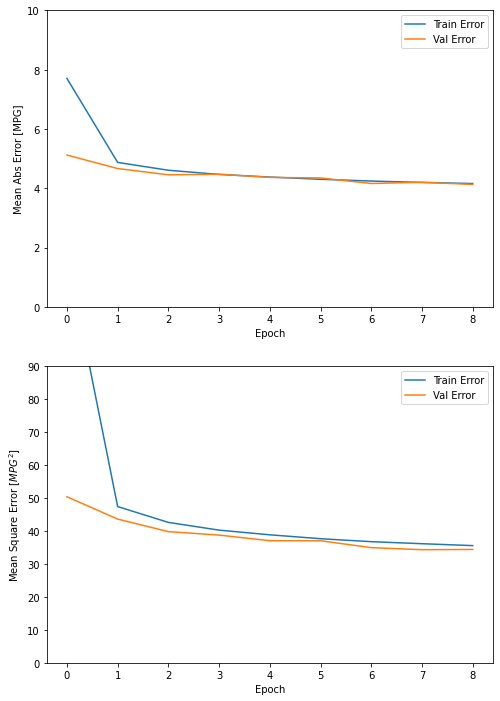

In [37]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],label = 'Val Error')
  plt.ylim([0,90])
  plt.legend()
  plt.show()

plot_history(history)

## 검증

In [38]:
loss, mae, mse = model.evaluate(normed_test_data, normed_test_labels, verbose=0)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

테스트 세트의 평균 절대 오차:  4.15 MPG


## 예측

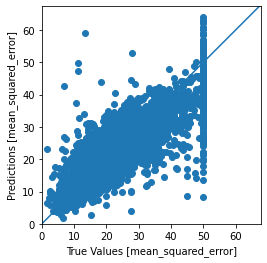

In [39]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(normed_test_labels, test_predictions)
plt.xlabel('True Values [mean_squared_error]')
plt.ylabel('Predictions [mean_squared_error]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-300, 300], [-300, 300])

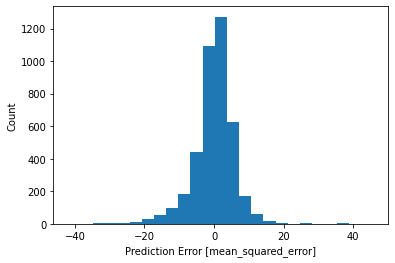

In [40]:
# 오차의 분포
error = test_predictions - normed_test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [mean_squared_error]")
_ = plt.ylabel("Count")